In [1]:
import pandas as pd
data = pd.read_csv('/home/jbar/EURUSD15.csv', delimiter='\t', names='Time	Open	High	Low	Close	Volume	Spread'.split())

import numpy as np
np.set_printoptions(suppress=True)

In [2]:
data.head()

,Time,Open,High,Low,Close,Volume,Spread
0,2020-01-13 14:00,1.11187,1.11218,1.11176,1.11208,2161,NaN
1,2020-01-13 14:15,1.11211,1.11227,1.11175,1.11204,2736,NaN
2,2020-01-13 14:30,1.11205,1.11267,1.11204,1.11211,3655,NaN
3,2020-01-13 14:45,1.11211,1.11247,1.11200,1.11240,2959,NaN
4,2020-01-13 15:00,1.11239,1.11268,1.11210,1.11252,2656,NaN


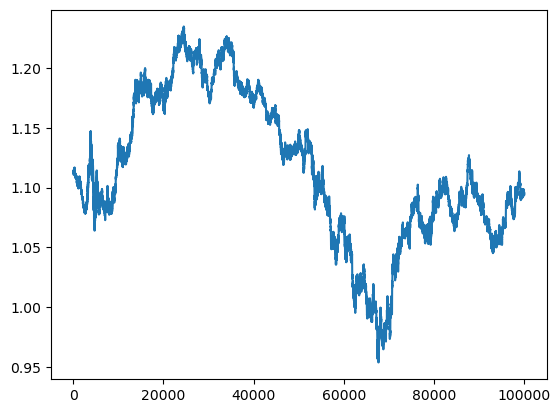

In [3]:
import matplotlib.pyplot as plt
timeseries = data['Close'].values
plt.plot(timeseries)

tensor([1.1121, 1.1120, 1.1121,  ..., 1.0947, 1.0950, 1.0950])
tensor([-3.9935e-05,  6.9976e-05,  2.9004e-04,  ...,  1.4997e-04,
         2.3997e-04,  7.9989e-05])


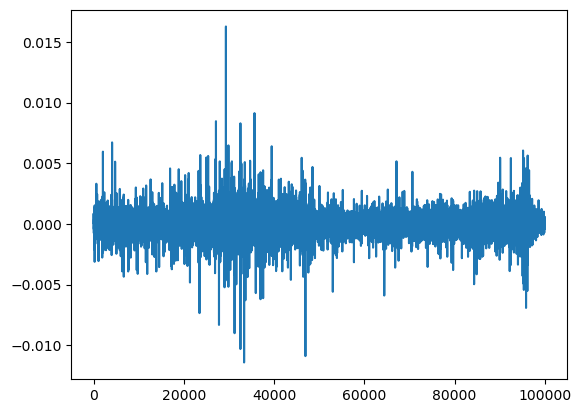

In [4]:
import torch

# Extract data

prices = torch.Tensor(data['Close'].values)[:100000]
print(prices)
print(prices.diff())
gains = prices.diff().div(prices[:-1]).flip(0)
plt.plot(gains)

tensor(-1.5605e-08) tensor(0.0005)
tensor([ 0.1387,  0.4162,  0.2601,  ...,  0.4952,  0.1195, -0.0681])


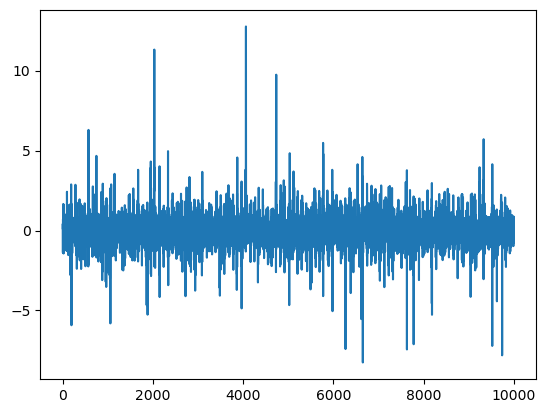

In [5]:
std, mean = torch.std_mean(gains)
print(mean, std)
gains_norm = (gains - mean) / std
print(gains_norm)
plt.plot(gains_norm[:10000])


In [47]:
# Define batches and loader

WINDOW_SIZE = 24
INPUT_SIZE = WINDOW_SIZE - 1
timeseries = gains_norm.unfold(0, WINDOW_SIZE, 1)
train_size = int(timeseries.shape[0] * 0.66)
test_size = timeseries.shape[0] - train_size
train_set, test_set = torch.utils.data.random_split(timeseries, [train_size, test_size])

# optimize this
x_train = torch.stack([sample[:INPUT_SIZE] for sample in train_set])
y_train = torch.stack([sample[INPUT_SIZE:] for sample in train_set])
x_test = torch.stack([sample[:INPUT_SIZE] for sample in test_set])
y_test = torch.stack([sample[INPUT_SIZE:] for sample in test_set])


loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=None, batch_sampler=None, shuffle=True, collate_fn=lambda sample: (sample[:INPUT_SIZE], sample[INPUT_SIZE:]))
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), shuffle=True, batch_size=1)
print(next(iter(loader)))
print(next(iter(loader)))

[tensor([[ 0.1002,  0.4513, -0.3008, -0.0167, -0.2171, -0.5514,  1.1200,  0.2507,
          0.3010,  0.0335, -0.0837,  0.4015,  0.8197,  2.2445,  0.1508,  0.2513,
          2.2140,  0.7047, -0.5367,  0.3188,  0.0168,  0.3019, -1.2239]]), tensor([[0.3355]])]
[tensor([[-0.5626, -0.6717, -0.3124,  0.8126, -0.4374,  0.1250,  0.2502, -0.3750,
         -0.8743,  0.1560, -0.3746, -0.2966, -0.3589,  0.0313, -0.0937, -0.4523,
         -0.3120, -0.0468, -0.3586,  1.9048, -0.2966, -0.1715, -1.2791]]), tensor([[0.2340]])]


In [48]:
import torch
import torch.nn as nn

HIDDEN_SIZE = 64
# HIDDEN_SIZE = INPUT_SIZE
class EquityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.GRU(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=1, batch_first=False)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [49]:
model = EquityModel()
idx = 532
print(x_train.shape)
print(x_train[idx])
model(x_train[idx:idx+1]), y_train[idx]

torch.Size([65984, 23])
tensor([-0.9170, -0.3979, -0.2767,  0.6920, -0.5707,  1.1424,  0.2076, -0.1211,
         0.9178,  0.6236,  0.5371,  0.2948, -0.0694,  0.9015, -0.3293,  0.7283,
         0.7807, -0.1040,  0.4164, -0.1214, -0.8496,  1.7008,  0.0696])


(tensor([[-0.0700]], grad_fn=<AddmmBackward0>), tensor([-0.8500]))

In [50]:
import numpy as np
def money_loss(output, target):
    mov_output, mov_target = output.sum(axis=-1), target.sum(axis=-1)
    # print(mov_output, mov_target)
    exponent = torch.sigmoid(mov_output * mov_target) * torch.pow(mov_target, 2) * 2 - 1
    return torch.pow(2, - exponent).sum()
    # return torch.pow(2, - torch.sign(output.sum(axis=-1)) * torch.sign(target.sum(axis=-1)) * torch.abs(target.sum(axis=-1))).sum()
a, b = torch.Tensor([[1, 1]]), torch.Tensor([[-2, -8]])
money_loss(a, b)

tensor(2.0000)

In [53]:
BATCH_SIZE = 64
model = EquityModel()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=1e-4)
loss_fn = money_loss
# loss_fn = nn.MSELoss()

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        # print(y_pred, y_train)
        # print(y_pred.sum(), y_train.sum())
        train_rmse = loss_fn(y_pred, y_train)
        # print(train_rmse)
        y_pred = model(x_test)
        test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 99702.5234, test RMSE 51408.4844
Epoch 1: train RMSE 99700.5469, test RMSE 51406.0000
Epoch 2: train RMSE 99692.3516, test RMSE 51408.9609
Epoch 3: train RMSE 99685.1562, test RMSE 51405.9492
Epoch 4: train RMSE 99678.2500, test RMSE 51410.8047
Epoch 5: train RMSE 99668.0781, test RMSE 51409.2695
Epoch 6: train RMSE 99664.4375, test RMSE 51420.1719
Epoch 7: train RMSE 99654.1328, test RMSE 51417.9805
Epoch 8: train RMSE 99647.3828, test RMSE 51425.9609
Epoch 9: train RMSE 99630.6250, test RMSE 51426.3320
Epoch 10: train RMSE 99620.5469, test RMSE 51426.2344
Epoch 11: train RMSE 99622.6641, test RMSE 51428.3438
Epoch 12: train RMSE 99607.3125, test RMSE 51435.0391
Epoch 13: train RMSE 99596.6250, test RMSE 51434.9961
Epoch 14: train RMSE 99582.4688, test RMSE 51437.9922
Epoch 15: train RMSE 99575.0859, test RMSE 51441.0391
Epoch 16: train RMSE 99565.7812, test RMSE 51450.5703
Epoch 17: train RMSE 99548.5625, test RMSE 51457.4844
Epoch 18: train RMSE 99540.5859, test 

KeyboardInterrupt: 